# LAB | Ensemble Methods

**Load the data**

In this challenge, we will be working with the same Spaceship Titanic data, like the previous Lab. The data can be found here:

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv

Metadata

https://github.com/data-bootcamp-v4/data/blob/main/spaceship_titanic.md

In this Lab, you should try different ensemble methods in order to see if can obtain a better model than before. In order to do a fair comparison, you should perform the same feature scaling, engineering applied in previous Lab.

In [25]:
from sklearn.datasets import  fetch_california_housing
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier


from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
spaceship = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv")
spaceship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Now perform the same as before:
- Feature Scaling
- Feature Selection


In [3]:
spaceship.shape

(8693, 14)

In [4]:
spaceship.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [5]:
spaceship.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [6]:
spaceship.dropna(inplace= True)
spaceship

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [7]:
# print(spaceship['Cabin'].nunique)
spaceship['Cabin'] = spaceship['Cabin'].str.split('/').str[0]
spaceship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [8]:
spaceship.drop(columns = ['PassengerId','Name'], inplace= True)

In [9]:
target = spaceship['Transported']

In [10]:
num_df = spaceship.select_dtypes('number')
cat_df = spaceship.select_dtypes(include=['object', 'category'])

In [11]:
cat_df = pd.get_dummies(cat_df, dtype = int)

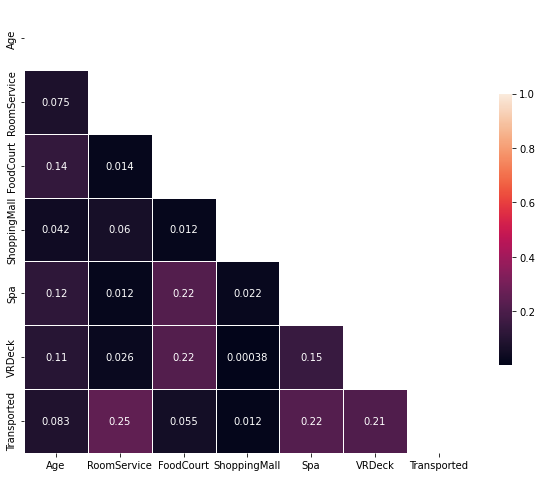

In [12]:
corr=np.abs(spaceship.corr())

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()

In [13]:
num_df2 = num_df.drop(columns = ['Spa'])
features = pd.concat([num_df2, cat_df], axis=1)
#df_spaceship2.head()

In [14]:
features = pd.concat([num_df, cat_df], axis=1)
#df_spaceship.head()

**Perform Train Test Split**

In [15]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [16]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=42)

In [17]:
#############################################  Logistical regression  #########################################################

In [18]:
normalizer = MinMaxScaler()

# fit to numerical columns
normalizer.fit(X_train)

# scale num columns
X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [19]:
log_reg = LogisticRegression()

In [20]:
log_reg.fit(X_train_norm, y_train)

C:\Users\Rike\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [21]:
pred = log_reg.predict(X_test_norm)

# print("MAE", mean_absolute_error(pred, y_test))
# print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", log_reg.score(X_test_norm, y_test))

R2 score 0.7760968229954615


In [22]:
##################################################  Decision tree  #############################################################

In [23]:
tree = DecisionTreeClassifier(max_depth=5)
tree2 = DecisionTreeClassifier(max_depth=20)

In [43]:
tree.fit(X_train_norm, y_train)
tree2.fit(X_train_norm, y_train)

DecisionTreeClassifier(max_depth=20)

In [44]:
X_train_norm

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,...,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True
0,0.316456,0.000000,0.056116,0.000000,0.028650,0.030094,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.455696,0.000000,0.088015,0.135232,0.124911,0.000049,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.430380,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.468354,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.278481,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5279,0.392405,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5280,0.278481,0.003261,0.006507,0.000163,0.000000,0.018194,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5281,0.316456,0.000000,0.003857,0.000000,0.081355,0.198712,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
5282,0.506329,0.000000,0.000704,0.000000,0.067074,0.068450,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [45]:
y_test

8441     True
8058     True
320      True
2548    False
8027    False
        ...  
7668     True
1697    False
546      True
4895     True
875      True
Name: Transported, Length: 1322, dtype: bool

In [46]:
pred = tree.predict(X_test_norm)

# print("MAE", mean_absolute_error(pred, y_test))
# print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", tree.score(X_test_norm, y_test))

R2 score 0.7806354009077155


C:\Users\Rike\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\Rike\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [47]:
pred2 = tree2.predict(X_test_norm)

# print("MAE", mean_absolute_error(pred, y_test))
# print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score for tree two:", tree2.score(X_test_norm, y_test)) #depth 20

R2 score for tree two: 0.764750378214826


C:\Users\Rike\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\Rike\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [48]:
X_train_norm = pd.DataFrame(X_train_norm, columns=X_train.columns)

tree_importance = {feature : importance for feature, importance in zip(X_train_norm.columns, tree.feature_importances_)}
tree_importance 

{'Age': 0.013735065144514877,
 'RoomService': 0.08913174978259746,
 'FoodCourt': 0.08848720884143982,
 'ShoppingMall': 0.0010563303139417741,
 'Spa': 0.08688604064596933,
 'VRDeck': 0.12174839505574336,
 'HomePlanet_Earth': 0.07218602865384029,
 'HomePlanet_Europa': 0.004592586906091379,
 'HomePlanet_Mars': 0.010549674437484757,
 'CryoSleep_False': 0.48437041371377465,
 'CryoSleep_True': 0.0,
 'Cabin_A': 0.0,
 'Cabin_B': 0.0,
 'Cabin_C': 0.0,
 'Cabin_D': 0.0,
 'Cabin_E': 0.015828343560735654,
 'Cabin_F': 0.0,
 'Cabin_G': 0.0,
 'Cabin_T': 0.0,
 'Destination_55 Cancri e': 0.0049053999090184945,
 'Destination_PSO J318.5-22': 0.0065227630348483,
 'Destination_TRAPPIST-1e': 0.0,
 'VIP_False': 0.0,
 'VIP_True': 0.0}

In [49]:
X_train_norm = pd.DataFrame(X_train_norm, columns=X_train.columns)

tree2_importance = {feature : importance for feature, importance in zip(X_train_norm.columns, tree.feature_importances_)}
tree2_importance 

{'Age': 0.013735065144514877,
 'RoomService': 0.08913174978259746,
 'FoodCourt': 0.08848720884143982,
 'ShoppingMall': 0.0010563303139417741,
 'Spa': 0.08688604064596933,
 'VRDeck': 0.12174839505574336,
 'HomePlanet_Earth': 0.07218602865384029,
 'HomePlanet_Europa': 0.004592586906091379,
 'HomePlanet_Mars': 0.010549674437484757,
 'CryoSleep_False': 0.48437041371377465,
 'CryoSleep_True': 0.0,
 'Cabin_A': 0.0,
 'Cabin_B': 0.0,
 'Cabin_C': 0.0,
 'Cabin_D': 0.0,
 'Cabin_E': 0.015828343560735654,
 'Cabin_F': 0.0,
 'Cabin_G': 0.0,
 'Cabin_T': 0.0,
 'Destination_55 Cancri e': 0.0049053999090184945,
 'Destination_PSO J318.5-22': 0.0065227630348483,
 'Destination_TRAPPIST-1e': 0.0,
 'VIP_False': 0.0,
 'VIP_True': 0.0}

In [50]:
from sklearn.tree import export_text

tree_viz = export_text(tree, feature_names=list(X_train_norm.columns))
print(tree_viz)

|--- CryoSleep_False <= 0.50
|   |--- HomePlanet_Earth <= 0.50
|   |   |--- Cabin_E <= 0.50
|   |   |   |--- Age <= 0.03
|   |   |   |   |--- HomePlanet_Europa <= 0.50
|   |   |   |   |   |--- class: True
|   |   |   |   |--- HomePlanet_Europa >  0.50
|   |   |   |   |   |--- class: False
|   |   |   |--- Age >  0.03
|   |   |   |   |--- Age <= 0.47
|   |   |   |   |   |--- class: True
|   |   |   |   |--- Age >  0.47
|   |   |   |   |   |--- class: True
|   |   |--- Cabin_E >  0.50
|   |   |   |--- HomePlanet_Mars <= 0.50
|   |   |   |   |--- class: True
|   |   |   |--- HomePlanet_Mars >  0.50
|   |   |   |   |--- Age <= 0.62
|   |   |   |   |   |--- class: False
|   |   |   |   |--- Age >  0.62
|   |   |   |   |   |--- class: True
|   |--- HomePlanet_Earth >  0.50
|   |   |--- Destination_55 Cancri e <= 0.50
|   |   |   |--- Age <= 0.54
|   |   |   |   |--- Destination_PSO J318.5-22 <= 0.50
|   |   |   |   |   |--- class: True
|   |   |   |   |--- Destination_PSO J318.5-22 >  0.50
|

In [51]:
tree2_viz = export_text(tree2, feature_names=list(X_train_norm.columns))
print(tree2_viz)

|--- CryoSleep_False <= 0.50
|   |--- HomePlanet_Earth <= 0.50
|   |   |--- Cabin_E <= 0.50
|   |   |   |--- Age <= 0.03
|   |   |   |   |--- Cabin_F <= 0.50
|   |   |   |   |   |--- class: False
|   |   |   |   |--- Cabin_F >  0.50
|   |   |   |   |   |--- class: True
|   |   |   |--- Age >  0.03
|   |   |   |   |--- Age <= 0.47
|   |   |   |   |   |--- Age <= 0.44
|   |   |   |   |   |   |--- Cabin_A <= 0.50
|   |   |   |   |   |   |   |--- Cabin_F <= 0.50
|   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |   |--- Cabin_F >  0.50
|   |   |   |   |   |   |   |   |--- Age <= 0.28
|   |   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |   |   |--- Age >  0.28
|   |   |   |   |   |   |   |   |   |--- Age <= 0.30
|   |   |   |   |   |   |   |   |   |   |--- Destination_TRAPPIST-1e <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |   |   |   |   |--- Destination_TRAPPIST-1e >  0.50
|   |   |   |   |   

In [52]:
##### confusion matrix!!
from sklearn.tree import plot_tree

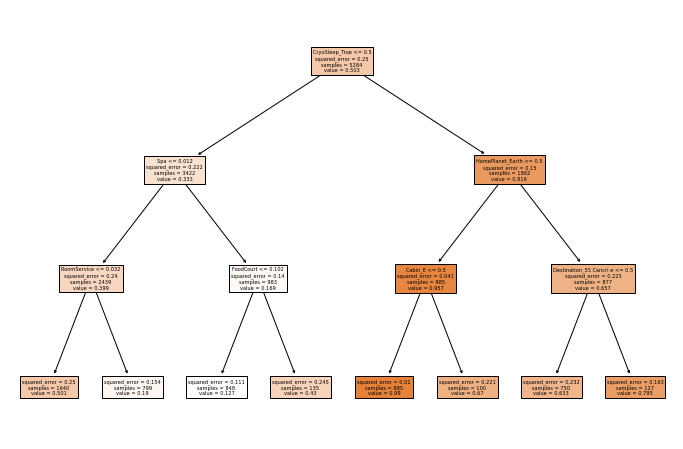

In [34]:
plt.figure(figsize=(12,8))  # Set plot size
plot_tree(tree, feature_names=X_train.columns, filled=True)

plt.show()

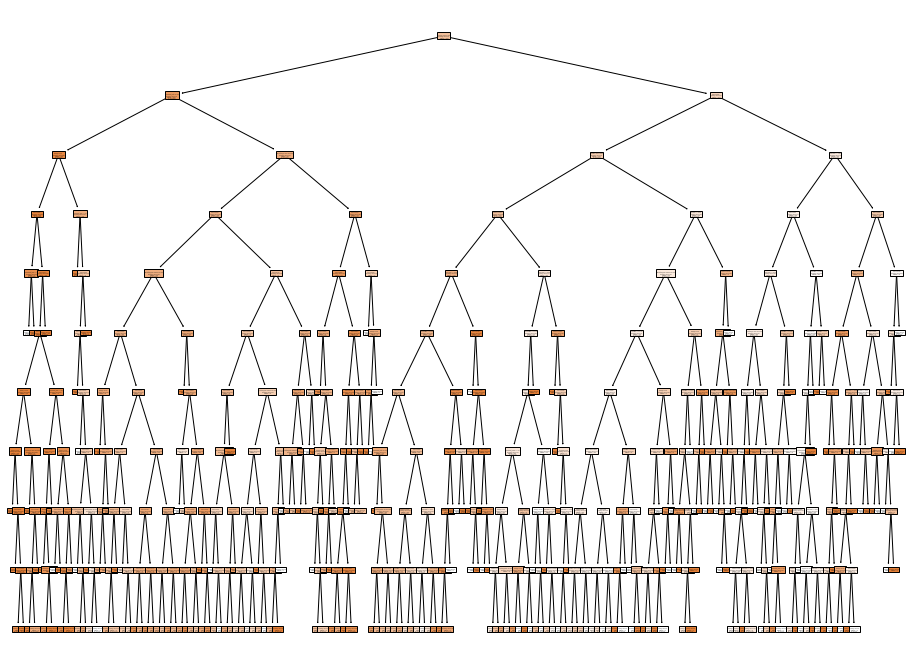

In [35]:
plt.figure(figsize=(16,12))  # Set plot size
plot_tree(tree2, feature_names=X_train.columns, filled=True)

plt.show()

**Model Selection** - now you will try to apply different ensemble methods in order to get a better model

- Bagging and Pasting

In [88]:
bagging_cla = BaggingClassifier(DecisionTreeClassifier(max_depth=30),
                               n_estimators=45,
                               max_samples = 1000)

In [89]:
bagging_cla.fit(X_train_norm, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=30),
                  max_samples=1000, n_estimators=45)

In [90]:
pred = bagging_cla.predict(X_test_norm)

# print("MAE", mean_absolute_error(pred, y_test))
# print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", bagging_cla.score(X_test_norm, y_test))

R2 score 0.8033282904689864


##### - Random Forests

In [115]:
forest = RandomForestClassifier(n_estimators=30,  # trees 
                             max_depth=3) # depth of each tree

In [116]:
forest.fit(X_train_norm, y_train)

RandomForestClassifier(max_depth=3, n_estimators=30)

In [117]:
pred = forest.predict(X_test_norm)

# print("MAE", mean_absolute_error(pred, y_test))
# print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", forest.score(X_test_norm, y_test))

R2 score 0.7503782148260212


- Gradient Boosting

In [118]:
gb_cla = GradientBoostingClassifier(max_depth=40,
                                   n_estimators=50)

In [119]:
gb_cla.fit(X_train_norm, y_train)

GradientBoostingClassifier(max_depth=40, n_estimators=50)

In [121]:
pred = gb_cla.predict(X_test_norm)

# print("MAE", mean_absolute_error(pred, y_test))
# print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", gb_cla.score(X_test_norm, y_test))

R2 score 0.764750378214826


- Adaptive Boosting

In [134]:
ada_cla = AdaBoostClassifier(DecisionTreeClassifier(max_depth=50), # generally it would be shorter than an unique tree
                            n_estimators=50)

In [135]:
ada_cla.fit(X_train_norm, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=50))

In [136]:
pred = ada_cla.predict(X_test_norm)

# print("MAE", mean_absolute_error(pred, y_test))
# print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", ada_cla.score(X_test_norm, y_test))

R2 score 0.7844175491679274


Which model is the best and why?

In [40]:
#Bagging and Pasting seems to be the best model
# Bagging and Pasting are great choices for categorical classification tasks due to their ability to stabilize predictions, 
# especially when using high-variance models like decision trees that benefit from this ensemble approach.